In [59]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, accuracy_score, recall_score
import plotly.express as px
import plotly.figure_factory as ff

In [2]:
df = pd.read_csv("../src/conversion_data_train.csv")

## EDA

In [3]:
df.shape

(284580, 6)

In [4]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [62]:
df["converted"].value_counts() / df.shape[0] * 100

converted
0    96.774194
1     3.225806
Name: count, dtype: float64

In [5]:
(df.isna().sum() / df.shape[0]).apply(lambda x: f"{round(x * 100)} %")

country                0 %
age                    0 %
new_user               0 %
source                 0 %
total_pages_visited    0 %
converted              0 %
dtype: object

In [6]:
corr_matrix = df.select_dtypes(exclude="object").corr()

ff.create_annotated_heatmap(corr_matrix.round(2).values, 
                            x=corr_matrix.columns.tolist(),
                            y=corr_matrix.index.tolist())

In [7]:
df_sample = df.sample(10000)

In [ ]:
for column in df_sample.columns:
    fig = px.histogram(df_sample[column])
    fig.show()

## Pipeline

In [63]:
target = "converted"

X = df.drop(target, axis=1)
Y = df[target]

In [64]:
numeric_features = []
categorical_features = []
for column, type in X.dtypes.items():
    if ("float" in str(type)) or ("int" in str(type)):
        numeric_features.append(column)
    else:
        categorical_features.append(column)
print(numeric_features)
print(categorical_features)

['age', 'new_user', 'total_pages_visited']
['country', 'source']


In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("num", "passthrough", numeric_features)  # no preprocessing
    ]
)

In [72]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(criterion="entropy"))
])

In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

## Training

In [25]:
params = {
    "model__max_depth": [2, 4, 6, 8, 10],
    "model__min_samples_leaf": [5],
    "model__min_samples_split": [2],
}

gridsearch = GridSearchCV(pipeline, param_grid=params, cv=3)
gridsearch.fit(X_train, Y_train)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best validation accuracy :  0.9834712558858669


In [85]:
params = {
    "model__max_depth": [10],
    "model__min_samples_leaf": [5],
    "model__min_samples_split": [2],
}

gridsearch = GridSearchCV(pipeline, param_grid=params, cv=3)
gridsearch.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['country',
                                                                          'source']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'new_user',
                                                                          'total_pages_visited'])])),
                                       ('model',
                                        DecisionTreeClassifier(criterion='entropy'))]),
             param_grid={'model__max_depth': [10],
                         'model__min_samples_leaf': [5],
                         'model__min_samples_split': [2]})

In [86]:
Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

## Performances

In [87]:
print("f1-score on training set :", f1_score(Y_train, Y_train_pred))
print("accuracy on training set :", accuracy_score(Y_train, Y_train_pred))
print("recall :", recall_score(Y_train, Y_train_pred))

f1-score on training set : 0.7713113508585321
accuracy on training set : 0.986778761683885
recall : 0.6932532095055995


In [88]:
print("f1-score on testing set :", f1_score(Y_test, Y_test_pred))
print("accuracy on testing set :", accuracy_score(Y_test, Y_test_pred))
print("recall :", recall_score(Y_test, Y_test_pred))

f1-score on testing set : 0.7491039426523297
accuracy on testing set : 0.9852414083913135
recall : 0.6749192680301399


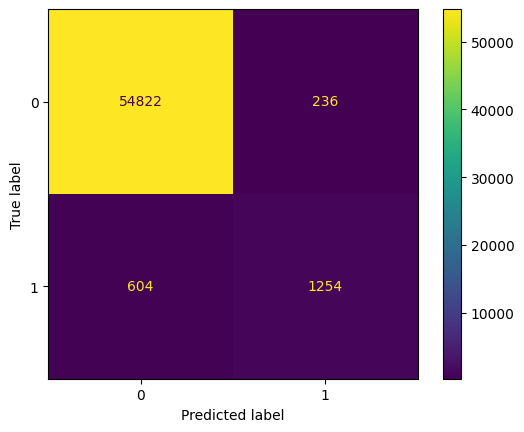

In [89]:
ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_pred)

## In production

In [90]:
df_prod = pd.read_csv("../src/conversion_data_test.csv")
Y_prod_pred = gridsearch.predict(df_prod)

In [91]:
Y_prod_pred

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [92]:
df_predictions = pd.DataFrame(Y_prod_pred, columns=["Prediction"])
df_predictions.to_csv("../deliveries/conversion_data_test_predictions_TRISTAN-DecisionTreeClassifier.csv", index=False)